# ***KAN介绍***

### 作者： Yutao Jin

####    0.MLP回顾

    0.1 简介
线性组合 -> 非线性激活 ：实现非线性空间变换。即通过多个线性决策边界和激活函数得到复杂、非线性的决策边界空间。  
随着层数增加（深度越来越深），模型表示能力越强，表征非线性能力越强。


    0.2 优点
易于理解基本的前向传播、反向传播算法，并能快速实现


    0.3 缺点
梯度爆炸、消失  
参数效率低、量大  
处理高维数据能力有限  
长序列记忆问题

$${\rm MLP}({\bf x})={\bf W}_{L-1}\circ\sigma\circ\cdots\circ {\bf W}_1\circ\sigma\circ {\bf W}_0\circ {\bf x}$$

####    1. 前置知识：b-splines B样条函数


    1.1 简介
基于一系列控制点来定义曲线或曲面， 即通过一个Basic函数集合和控制点集合来拟合函数


    1.2公式
令控制点为 Pi(i=0,1,...,n) 共 n+1个， 令一节点向量 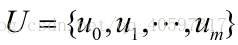共m个， k为曲线次数。  
三者满足 m = k + n + 1  
则有：  
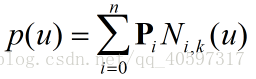
其中，  
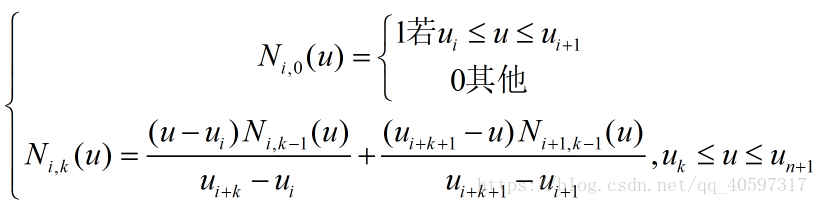
形象演示：  
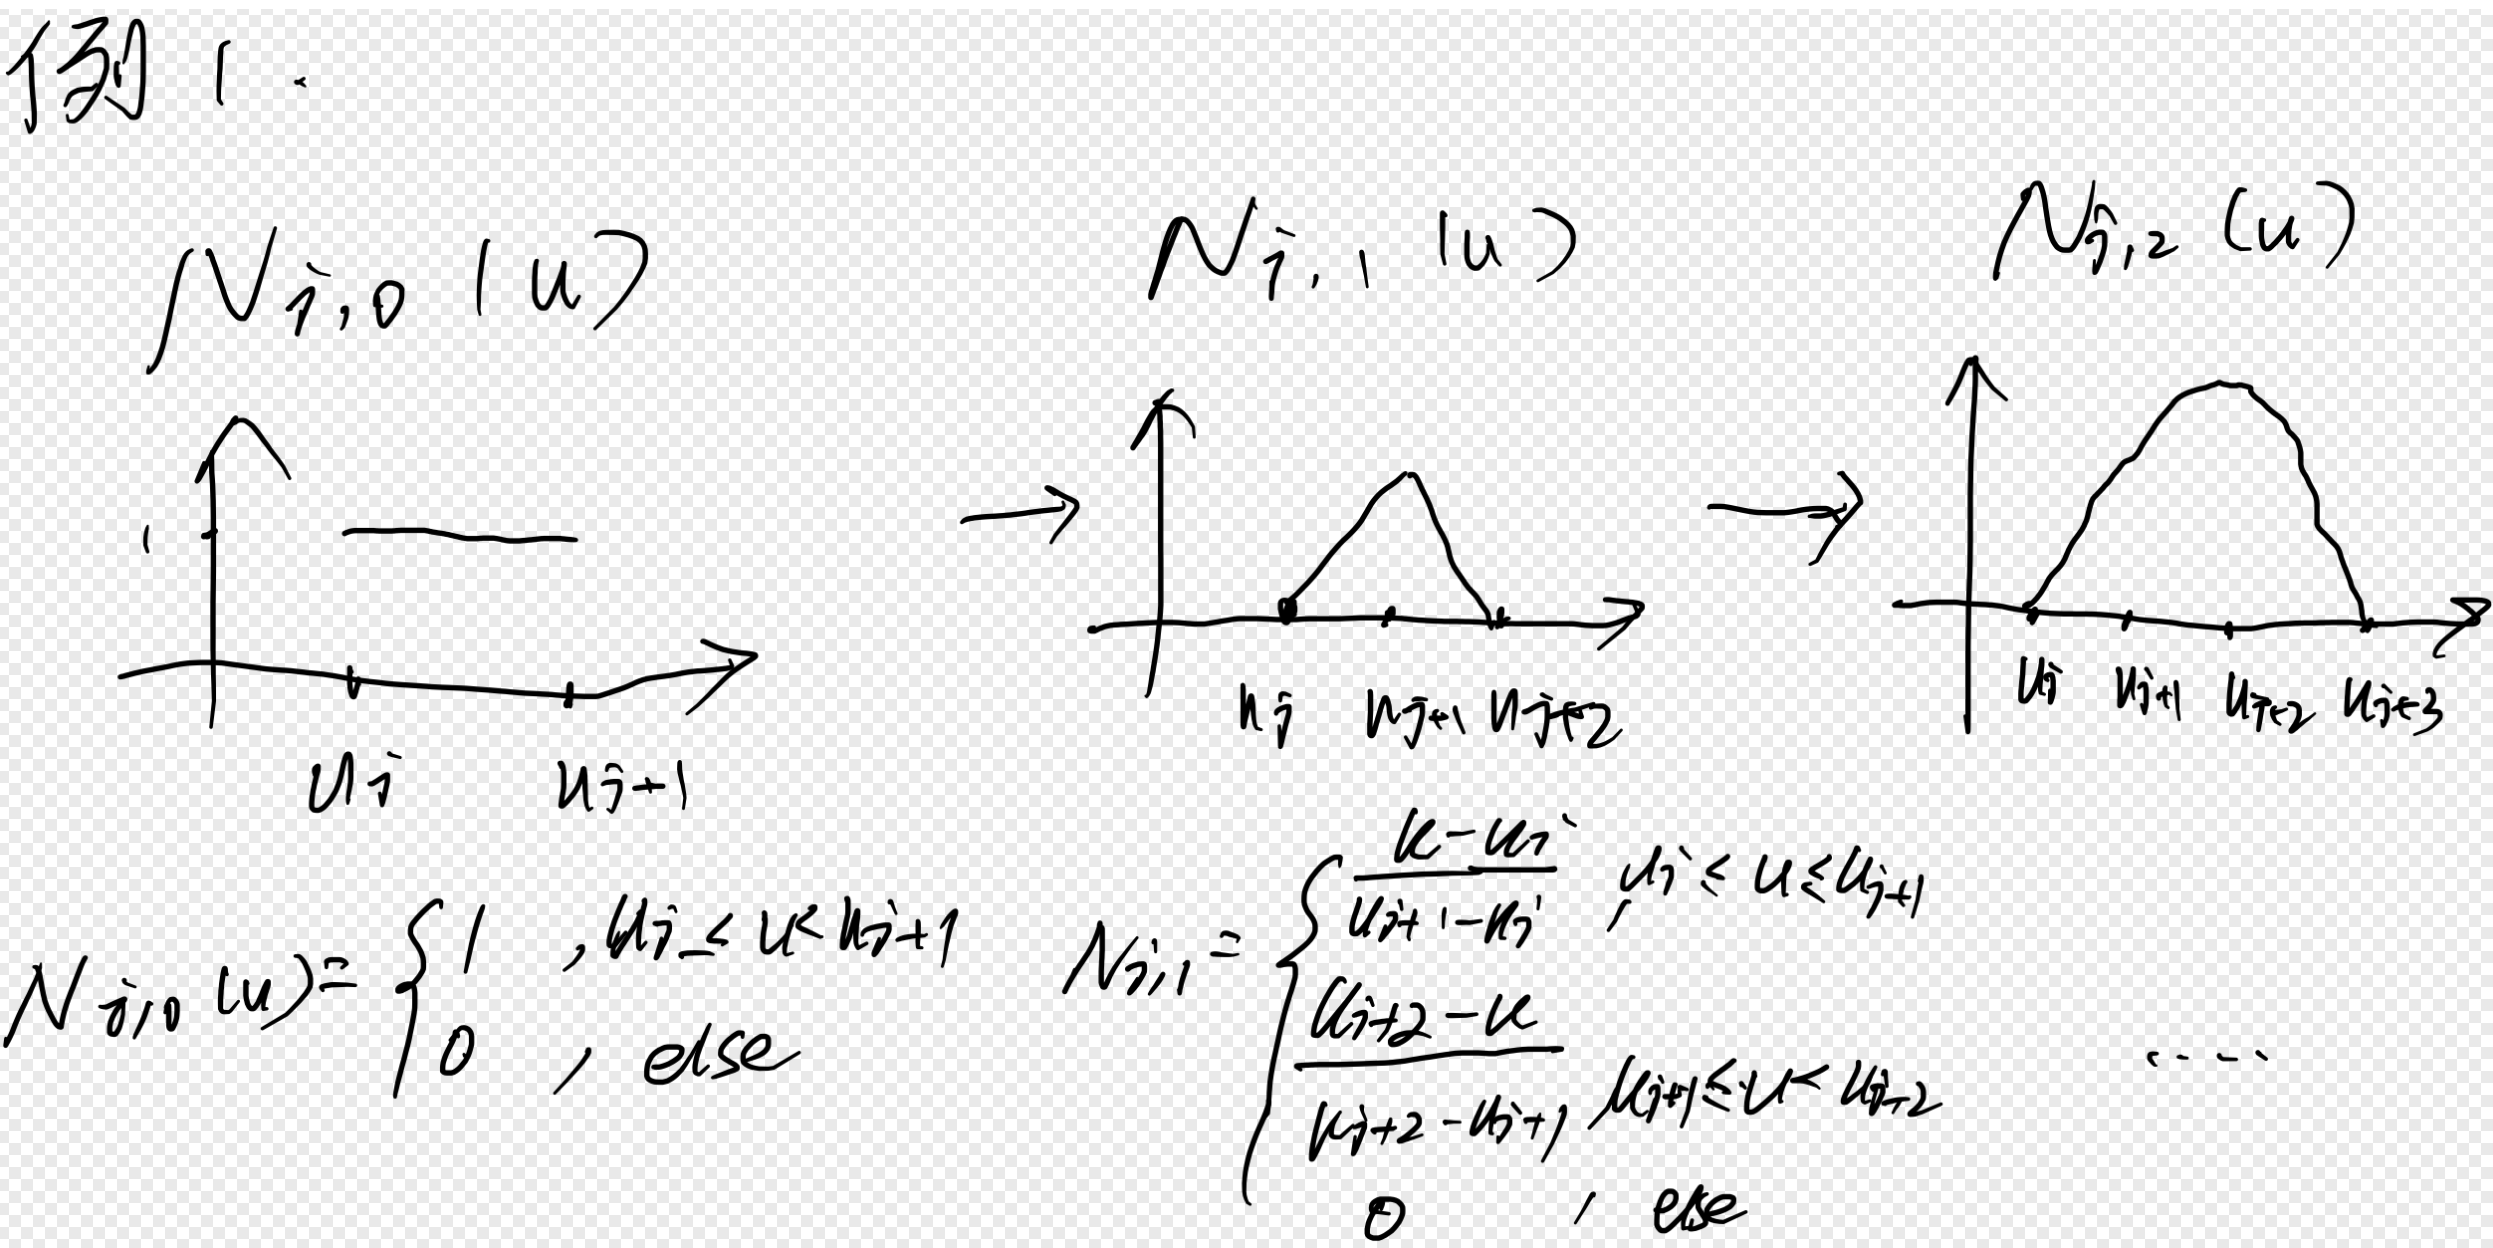


    1.3 迭代例子  
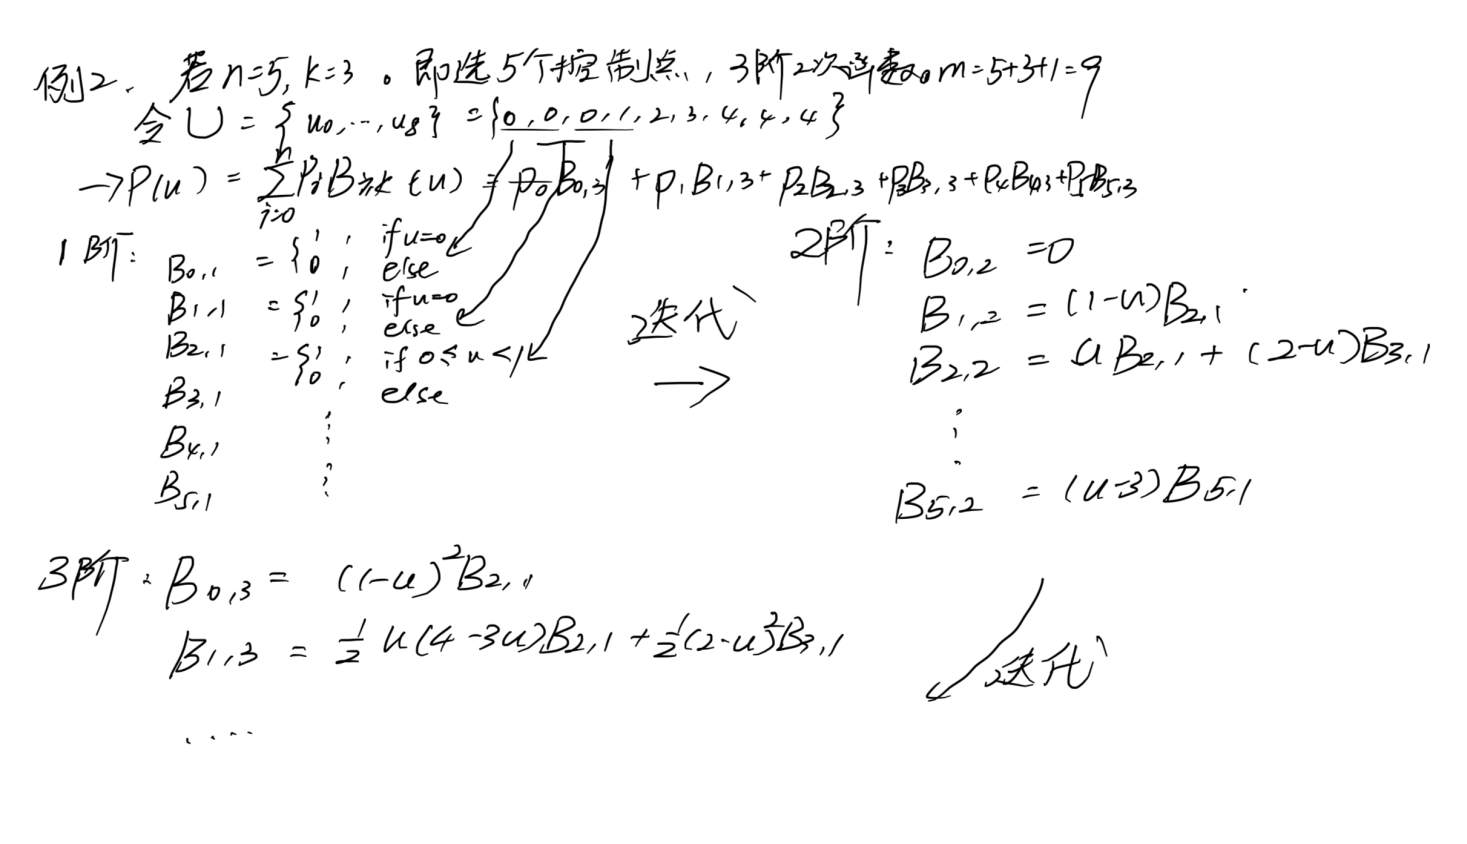  

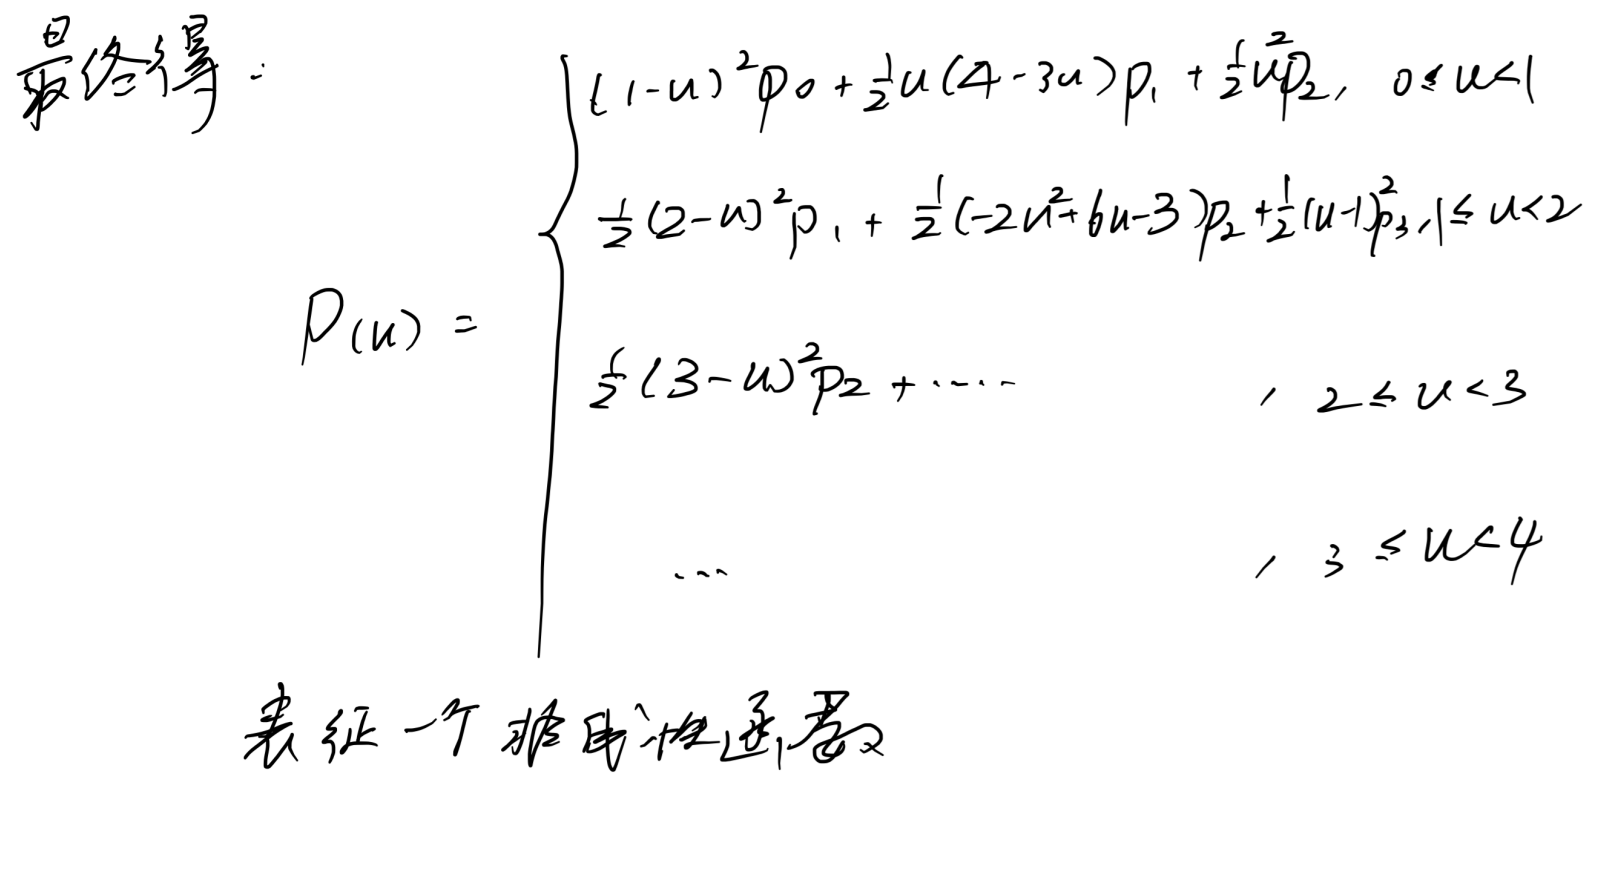

2
1
torch.Size([100, 1, 8])


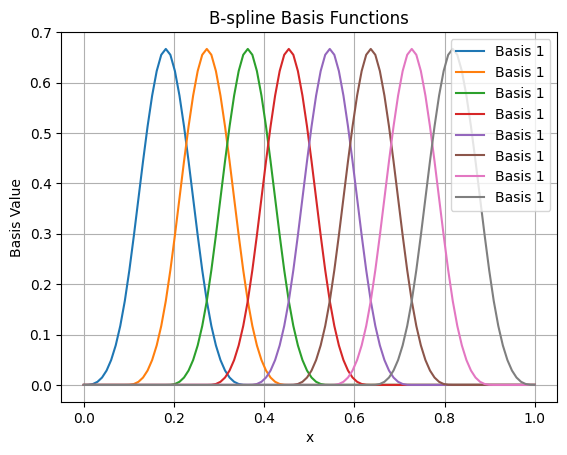

In [2]:
#获取基础样条函数 Bi(x)
import KAN
import torch
import torch.nn.functional as F
import math
from torchinfo import summary
import matplotlib.pyplot as plt


model = KAN.KANLinear(1, 2)

x_values = torch.linspace(0, 1, 100).unsqueeze(1)  # 100个样本点
print(x_values.dim())
print(x_values.size(1))

bases = model.b_splines_pkt_show(x_values)  # 前向传播
print(bases.shape)
# 绘制每个基函数
for i in range(bases.size(1)):  # 遍历每个基函数
    plt.plot(x_values.numpy(), bases[:, i, :].numpy(), label=f'Basis {i+1}')

plt.title('B-spline Basis Functions')
plt.xlabel('x')
plt.ylabel('Basis Value')
plt.legend()
plt.grid()
plt.show()

#shape = self.grid_size + self.spline_order


###     2.Kolmogorov-Arnold 定理

>用一组连续简单函数表示任何一个多变量的连续函数

$$f(x) = f(x_1,...,x_n)=\sum_{q=1}^{2n+1}\Phi_q(\sum_{p=1}^n \phi_{q,p}(x_p))$$

>相当于两层的神经网络但是直接对输入进行激活，激活函数不固定可以学习

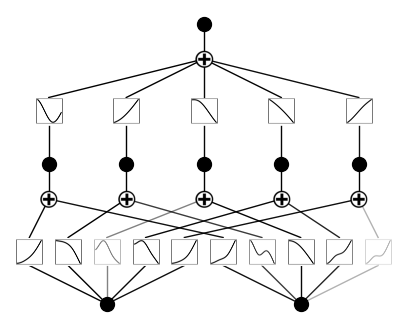

#### 与MLP的万能近似定理对比：

>MLP：线性组合 -> 非线性激活  
>KA：每个输入非线性激活 -> 线性组合

个人认为：KA训练慢的原因主要是由于每个输入都非线性激活很难训练（通过反求解线性方程组训练Ci的方式十分消耗计算资源），但是KA由于找到了准确的激活函数因此参数量比较MLP少，推理速度会很快（部署到边缘设备可能会得到更好的效果）。


###     3.KAN架构

>对KA定理的简化 -> 使得网络能够做深

$${\rm KAN}({\bf x})={\bf \Phi}_{L-1}\circ\cdots \circ{\bf \Phi}_1\circ{\bf \Phi}_0\circ {\bf x}$$

假设输入为：$${ x_{\rm l} } = \begin{bmatrix} x_{1}\\ x_{2} \\ \cdots \\ x_{n_{\rm l}} \end{bmatrix}$$

其中 $${\bf \Phi}_{L}$$ 为矩阵形式的激活函数， 负责对输入向量激活  
$${\bf \Phi}= \begin{pmatrix} \phi_{1,1}(\cdot) & \cdots & \phi_{1,n_{\rm l}}(\cdot) \\ \vdots & & \vdots \\ \phi_{n_{\rm l+1},1}(\cdot) & \cdots & \phi_{n_{\rm l+1},n_{\rm l}}(\cdot) \end{pmatrix}$$

列元素数表示下一层layer+1神经元个数，$$共2n_{\rm l} + 1个$$（比如上一层输入2，下一层共5个神经元），行元素数表示本层layer神经元个数.  
$$  x_{\rm l+1} = x_{\rm l} * {\bf \Phi} $$
注：行x列得到下一层的一个神经元  
这就是KA定理所设计的网络，但这种网络很难做深。

$$因此，KAN把n_{\rm l+1}的数量不再设置为2n_{\rm l} + 1，而是设置为n_{\rm l}+1。或者任意多个隐藏节点$$

（比如上一层输入2，下一层共3个神经元）

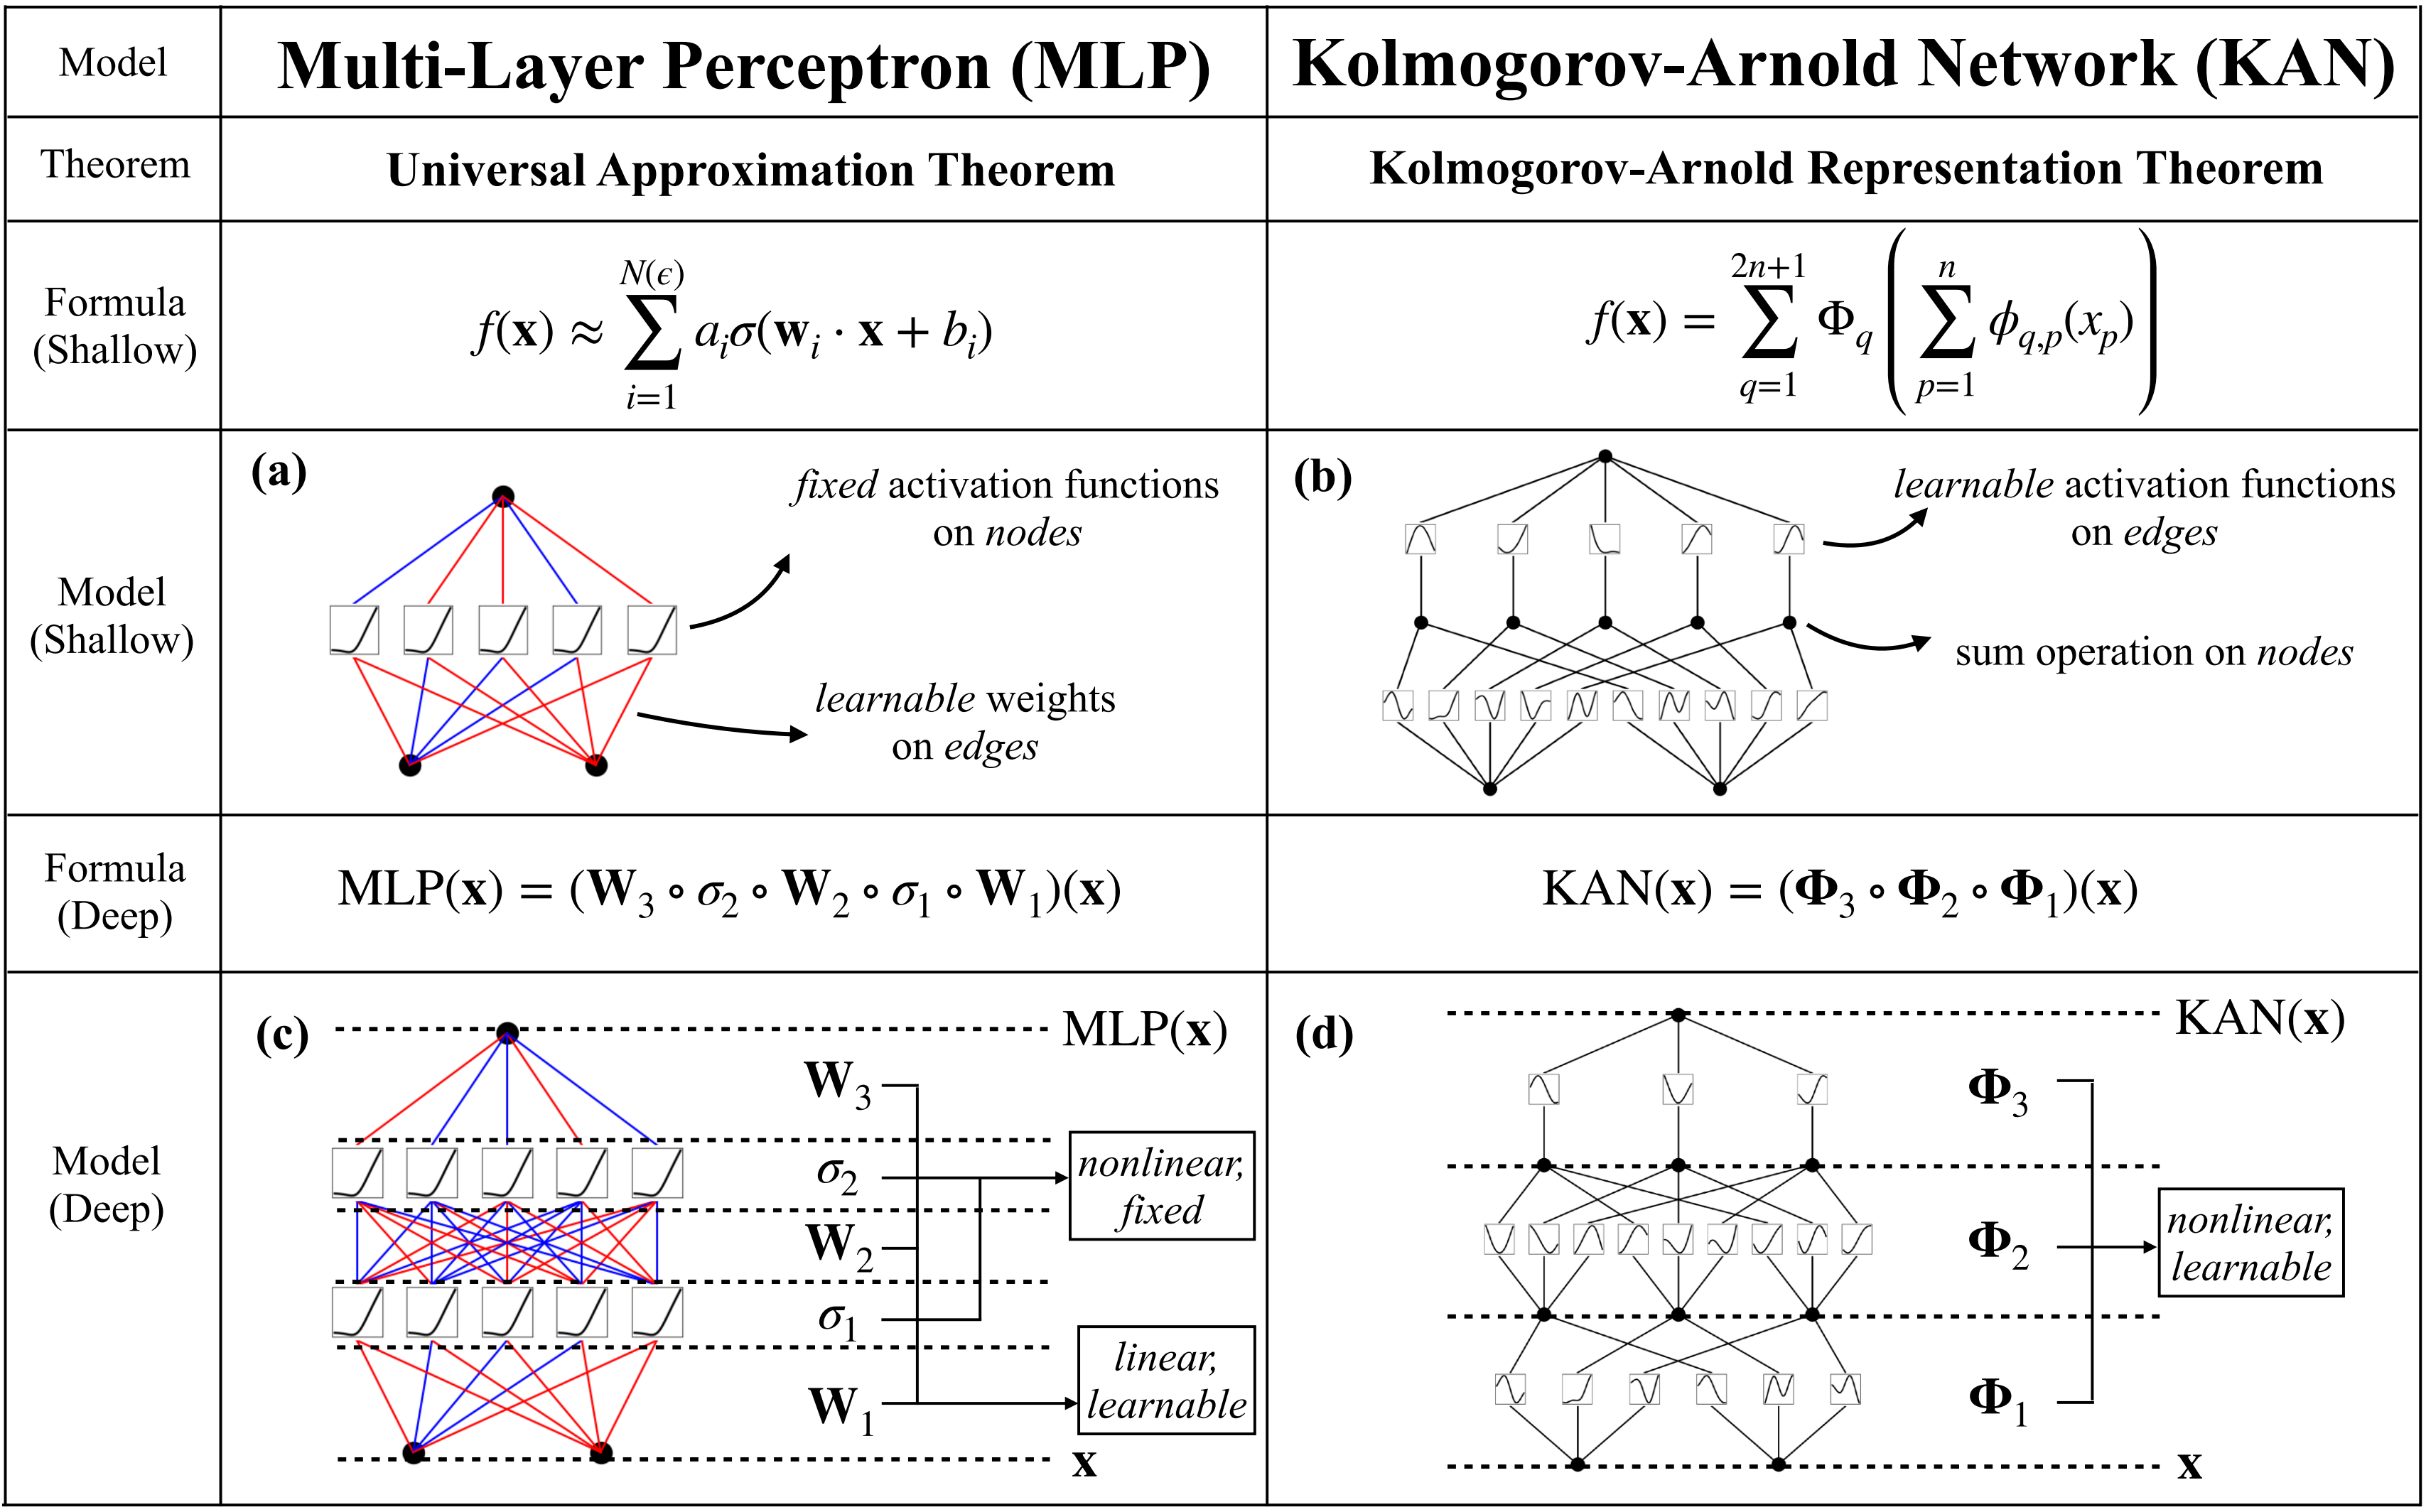

这样，就能够做的更深。  
上图反映的KAN形状就是$$[n,n+1,n+1,1]$$
而KA网络形状是$$[n,2n+1,1]$$

>KAN 的激活函数

$$\phi(x) = w(b(x) + splines(x))$$

w是缩放因子，用来控制整体大小， 可训练。  
b(x) 是SiLU激活函数。  
splines是B-spline b样条函数函数。  

通过可训练的激活函数， 可以得到想要的激活函数形状

####    5. 示例（官方代码）


In [3]:
from kan import *
torch.set_default_dtype(torch.float64)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# create a KAN: 2D inputs, 1D output, and 5 hidden neurons. cubic spline (k=3), 5 grid intervals (grid=5).
model = KAN(width=[2,5,1], grid=3, k=3, seed=42, device=device)

cuda
checkpoint directory created: ./model
saving model version 0.0


拟合一个函数

In [4]:
from kan.utils import create_dataset
#  f(x,y) = exp(sin(pi*x)+y^2)
f = lambda x: torch.exp(torch.sin(x) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2, device=device)
dataset['train_input'].shape, dataset['train_label'].shape

(torch.Size([1000, 2]), torch.Size([1000, 2]))

训练

In [5]:
model.fit(dataset, opt="LBFGS", steps=50, lamb=0.001);

| train_loss: 7.14e-01 | test_loss: 7.03e-01 | reg: 8.47e+00 | : 100%|█| 50/50 [00:16<00:00,  2.98it

saving model version 0.1


图形化

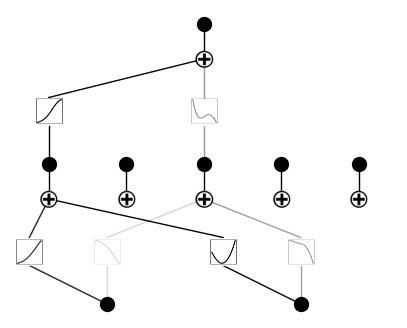

In [6]:
model.plot()

简化

saving model version 0.2


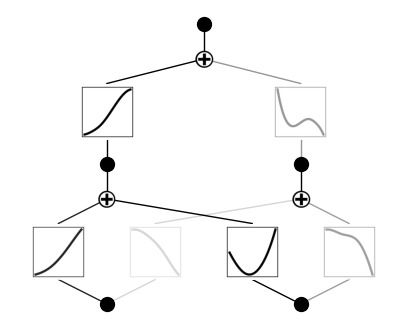

In [7]:
model = model.prune()
model.plot()

查看结果

In [8]:
mode = "auto" # "manual"

if mode == "manual":
    # manual mode
    model.fix_symbolic(0,0,0,'sin');
    model.fix_symbolic(0,1,0,'x^2');
    model.fix_symbolic(1,0,0,'exp');
elif mode == "auto":
    # automatic mode
    lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
    model.auto_symbolic(lib=lib)

fixing (0,0,0) with sin, r2=0.9998906833911809, c=2
fixing (0,0,1) with sin, r2=0.9996652523199759, c=2
fixing (0,1,0) with x^2, r2=0.9986413133476184, c=2
fixing (0,1,1) with exp, r2=0.9955131578133981, c=2
fixing (1,0,0) with sin, r2=0.998879691813062, c=2
fixing (1,1,0) with x, r2=0.2111917646242357, c=1
saving model version 0.3


fixing (1,0,0) with sin, r2=0.998879691813062, c=2
fixing (1,1,0) with x, r2=0.2111917646242357, c=1
可以看出训练的拟合结果是对的

继续训练

In [9]:
model.fit(dataset, opt="LBFGS", steps=50);
model = model.refine(10)
model.fit(dataset, opt="LBFGS", steps=50);

| train_loss: 7.15e-01 | test_loss: 7.04e-01 | reg: 0.00e+00 | : 100%|█| 50/50 [00:19<00:00,  2.58it


saving model version 0.4
saving model version 0.5


| train_loss: 7.15e-01 | test_loss: 7.03e-01 | reg: 0.00e+00 | : 100%|█| 50/50 [00:19<00:00,  2.60it

saving model version 0.6


In [10]:
mode = "auto" # "manual"

if mode == "manual":
    # manual mode
    model.fix_symbolic(0,0,0,'sin');
    model.fix_symbolic(0,1,0,'x^2');
    model.fix_symbolic(1,0,0,'exp');
elif mode == "auto":
    # automatic mode
    lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
    model.auto_symbolic(lib=lib)

skipping (0,0,0) since already symbolic
skipping (0,0,1) since already symbolic
skipping (0,1,0) since already symbolic
skipping (0,1,1) since already symbolic
skipping (1,0,0) since already symbolic
skipping (1,1,0) since already symbolic
saving model version 0.7


####    5. 尝试fashion-minist分类效果

##### 5.1获取数据集

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# datasets
trainset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=True,
    transform=transform)
testset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=False,
    transform=transform)

# dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                        shuffle=True, num_workers=2)
                                        
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False, num_workers=2)

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))



创建数据集

In [40]:
torch.__version__
import pytorch_lightning as pl
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/fashion_mnist_experiment_3')

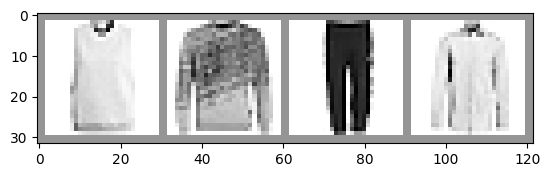

In [41]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

img_grid = torchvision.utils.make_grid(images)
# show images
matplotlib_imshow(img_grid, one_channel=True)
# write to tensorboard
writer.add_image('four_fashion_mnist_images', img_grid)




定义模型

In [44]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics import Accuracy
from KAN import *
# 定义模型 - KAN
class Net(nn.Module):
    def __init__(self, activation_fn = torch.nn.SiLU):
        super().__init__()
        self.activation_fn = activation_fn  # 通过参数指定激活函数
        self.layer_1 = KANLinear(28 * 28, 128, base_activation=self.activation_fn)
        self.layer_2 = KANLinear(128, 10, base_activation=self.activation_fn)
        self.train_accuracy = Accuracy(task='multiclass', num_classes=10)
        self.val_accuracy = Accuracy(task='multiclass', num_classes=10)
        self.test_accuracy = Accuracy(task='multiclass', num_classes=10)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # 展开图像为一维向量
        x = F.relu(self.layer_1(x))  # 应用 ReLU 激活函数
        x = self.layer_2(x)  # 第二个全连接层
        return F.log_softmax(x, dim=1)  # 使用 log_softmax 作为输出

# 定义模型 - MLP
class Net_MLP(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer_1 = nn.Linear(28 * 28, 128)
        self.layer_2 = nn.Linear(128, 10)
        self.train_accuracy = Accuracy(task='multiclass', num_classes=10)
        self.val_accuracy = Accuracy(task='multiclass', num_classes=10)
        self.test_accuracy = Accuracy(task='multiclass', num_classes=10)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # 展开图像为一维向量
        x = F.relu(self.layer_1(x))  # 应用 ReLU 激活函数
        x = self.layer_2(x)  # 第二个全连接层
        return F.log_softmax(x, dim=1)  # 使用 log_softmax 作为输出


net = Net()
net_mlp = Net_MLP()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_mlp.parameters(), lr=0.001, momentum=0.9)

writer.add_graph(net_mlp, images)




![屏幕截图 2024-11-15 175053.png](<attachment:屏幕截图 2024-11-15 175053.png>)
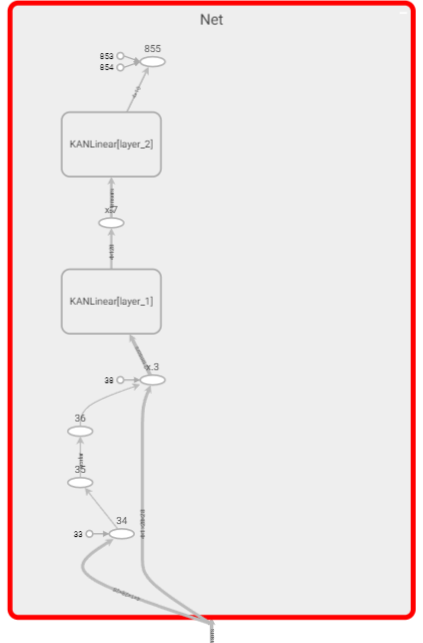

开始训练

In [45]:
def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig
    
running_loss = 0.0
for epoch in range(1,10):  # loop over the dataset multiple times

    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net_mlp(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:    # every 1000 mini-batches...

            # ...log the running loss
            writer.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(trainloader) + i)

            # ...log a Matplotlib Figure showing the model's predictions on a
            # random mini-batch
            writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(net_mlp, inputs, labels),
                            global_step=epoch * len(trainloader) + i)
            running_loss = 0.0
        
print('Finished Training')


Finished Training


In [31]:
# 1. gets the probability predictions in a test_size x num_classes Tensor
# 2. gets the preds in a test_size Tensor
# takes ~10 seconds to run
class_probs = []
class_label = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        output = net(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]

        class_probs.append(class_probs_batch)
        class_label.append(labels)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_label = torch.cat(class_label)

# helper function
def add_pr_curve_tensorboard(class_index, test_probs, test_label, global_step=0):
    '''
    Takes in a "class_index" from 0 to 9 and plots the corresponding
    precision-recall curve
    '''
    tensorboard_truth = test_label == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index],
                        tensorboard_truth,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

# plot all the pr curves
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_label)

KAN训练时长：20min仍然没有训练好10个epoch  
![屏幕截图 2024-11-15 180637.png](<attachment:屏幕截图 2024-11-15 180637.png>)  
MLP训练时长：11s训练完成10个epoch  
![屏幕截图 2024-11-15 194022.png](<attachment:屏幕截图 2024-11-15 194022.png>)
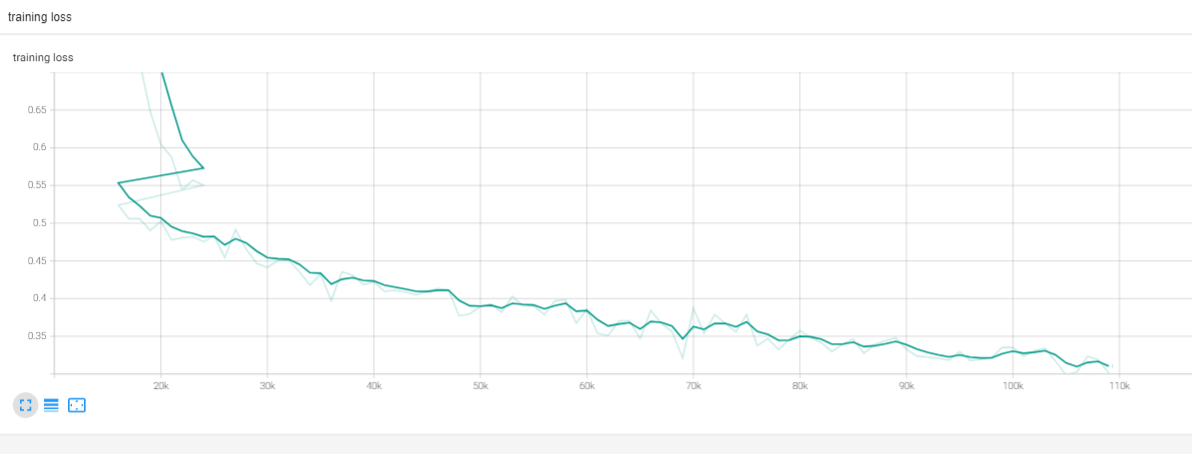
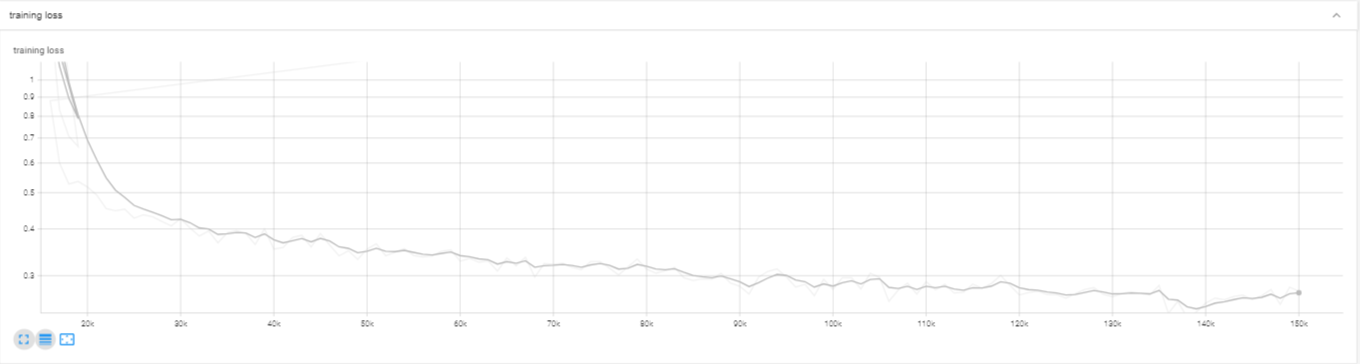

In [ ]:
# 训练模型
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/

####    6.总结
##### 6.1 MLP和KAN的区别：
从个人试验的简单结果看MLP似乎无论从训练速度和准确度以及拟合能力上都要优于KAN。  
KAN目前看在视觉任务上效果不佳，这也符合网上说的KAN不适合视觉任务的观点。
现在网上以及有KAN + CNN或者KAN + Transformer的尝试， 可能有效
个人认识： KAN 是一种更为精确，参数更少的MLP。几个MLP组合似乎也能直接表示一个KAN层
##### 6.2 KAN的优势：
推理速度快 ，适合部署    
适合数学和物理学以及依赖于公式和数学推导的学科，能够人为增加网络中的知识，并具有MLP所不具备的强可解释性（可以直观得到内部训练的函数性质）。  
能够高效剪枝，减少计算量，减少内存占用，适合在资源有限的情况下部署。  

##### 6.3 KAN的局限性：
训练速度极慢  
内部激活函数变得精确后， 个人认为是否对其泛化性能有影响，尚未有定论。  
KAN目前看在视觉任务上效果不佳  

##### 6.4 想到的一些idea：
1. KAN + Mamba 二者都有着不同的解释层面
2. KAN放在前两层学习大致的信息，后面使用MLP、transformer等学习具体的函数形式，提高泛化能力？  

